In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
import rgan
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('../config.json') as config_file:
    config = json.load(config_file)

In [ ]:
EPOCHS = 100
LR = 5e-5 
IN_SHAPE = config["image_shape_2"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution_2"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.75 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [3]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../../Simulations/data_model_2/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../../Simulations/data_model_2/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../../Simulations/data_model_2/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Models and physics-inspired loss function loading

In [5]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
disc_models = [rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE*MAGNIFICATION*N_MAG, latent_channel_count=8).to(device),
               rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE, latent_channel_count=8).to(device),
               rgan.Discriminator(residual_depth=4, in_shape=IN_SHAPE//(MAGNIFICATION*N_MAG), latent_channel_count=8).to(device),]
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, discriminators=disc_models, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Generator network parameters: {alpha_params/1e6}1e6")
param_list = []
for model in disc_models:
    param_list += list(model.parameters())
disc_opt = torch.optim.Adam(params=param_list,lr=LR)
for i,model in zip(range(3),disc_models):
    params = sum(p.numel() for p in model.parameters())
    print(f"Discriminator network {i} parameters: {params/1e6}e6")

Generator network parameters: 0.9004221e6
Discriminator network 0 parameters: 0.149425e6
Discriminator network 1 parameters: 0.051121e6
Discriminator network 2 parameters: 0.026545e6


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

### Defining functions that sample the model's performance

In [7]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


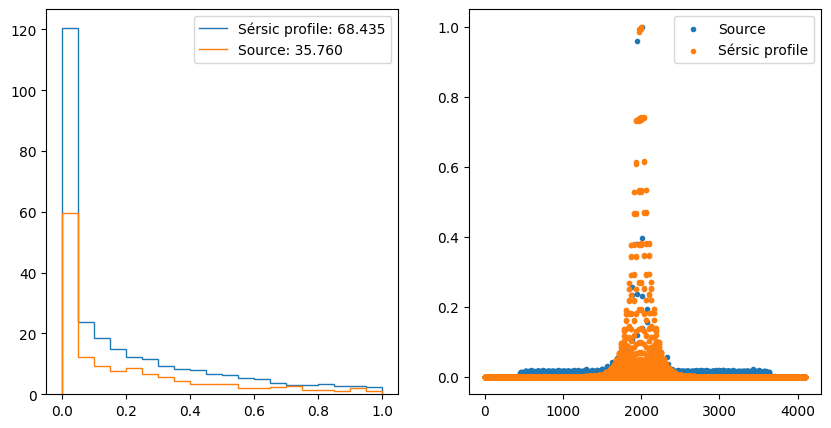

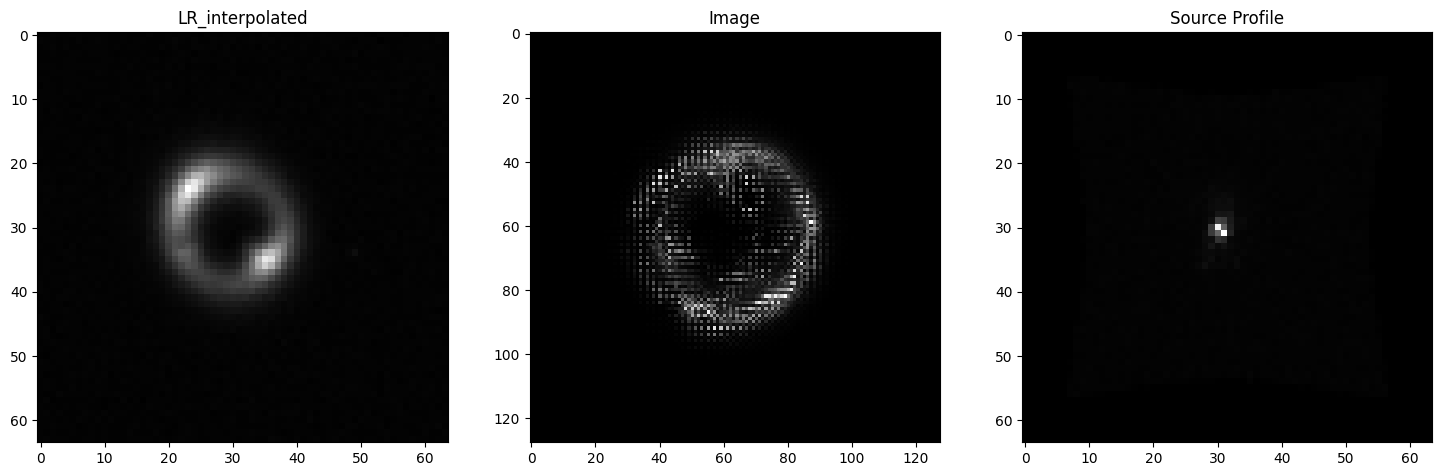

In [8]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required.

In [9]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[], 'ad_loss':[], 'ad_val_loss':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    ad_losses = []
    alpha_model.train()
    for model in disc_models:
        model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual, ad_loss = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        disc_opt.zero_grad()
        ad_loss.backward()
        disc_opt.step()
        ad_losses.append(float(ad_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    history['ad_loss'].append(np.mean(ad_losses))
    alpha_model.eval()
    for model in disc_models:
        model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    ad_losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual, ad_val_loss = lens_loss(alpha, x)
        losses.append(float(val_loss))
        ad_losses.append(float(ad_val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses):
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    history['ad_val_loss'].append(np.mean(ad_losses))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)
    lens_loss.decay_vdl(DECAY)

Training epoch 1:   0%|          | 0/816 [00:00<?, ?it/s]

Training epoch 1: 100%|██████████| 816/816 [00:50<00:00, 16.22it/s]


Training at epoch 1/100: 0.019582862637060536 at LR=5e-05


Validation epoch 1: 100%|██████████| 204/204 [00:05<00:00, 34.22it/s]


Validation at epoch 1/100: 0.018013864938242766 at LR=5e-05


Training epoch 2: 100%|██████████| 816/816 [00:49<00:00, 16.39it/s]


Training at epoch 2/100: 0.015851821195717684 at LR=5e-05


Validation epoch 2: 100%|██████████| 204/204 [00:06<00:00, 33.74it/s]


Validation at epoch 2/100: 0.01105732486729382 at LR=5e-05


Training epoch 3: 100%|██████████| 816/816 [00:49<00:00, 16.33it/s]


Training at epoch 3/100: 0.010336293481112294 at LR=5e-05


Validation epoch 3: 100%|██████████| 204/204 [00:05<00:00, 34.11it/s]


Validation at epoch 3/100: 0.009295534646120287 at LR=5e-05


Training epoch 4: 100%|██████████| 816/816 [00:50<00:00, 16.06it/s]


Training at epoch 4/100: 0.00948155031644502 at LR=5e-05


Validation epoch 4: 100%|██████████| 204/204 [00:06<00:00, 33.93it/s]


Validation at epoch 4/100: 0.009009842881841548 at LR=5e-05


Training epoch 5: 100%|██████████| 816/816 [00:50<00:00, 16.15it/s]


Training at epoch 5/100: 0.008992464588635474 at LR=5e-05


Validation epoch 5: 100%|██████████| 204/204 [00:06<00:00, 33.93it/s]


Validation at epoch 5/100: 0.008558749551108727 at LR=5e-05


Training epoch 6: 100%|██████████| 816/816 [00:50<00:00, 16.22it/s]


Training at epoch 6/100: 0.008491018211227094 at LR=5e-05


Validation epoch 6: 100%|██████████| 204/204 [00:06<00:00, 33.55it/s]


Validation at epoch 6/100: 0.00846945747445502 at LR=5e-05


Training epoch 7: 100%|██████████| 816/816 [00:50<00:00, 16.16it/s]


Training at epoch 7/100: 0.007971981468418723 at LR=5e-05


Validation epoch 7: 100%|██████████| 204/204 [00:06<00:00, 33.30it/s]


Validation at epoch 7/100: 0.007652852442298158 at LR=5e-05


Training epoch 8: 100%|██████████| 816/816 [00:50<00:00, 16.15it/s]


Training at epoch 8/100: 0.007556041673524305 at LR=5e-05


Validation epoch 8: 100%|██████████| 204/204 [00:06<00:00, 33.62it/s]


Validation at epoch 8/100: 0.007729059741512745 at LR=5e-05


Training epoch 9: 100%|██████████| 816/816 [00:51<00:00, 15.98it/s]


Training at epoch 9/100: 0.007155433456657691 at LR=5e-05


Validation epoch 9: 100%|██████████| 204/204 [00:06<00:00, 32.82it/s]


Validation at epoch 9/100: 0.007153454080039142 at LR=5e-05


Training epoch 10: 100%|██████████| 816/816 [00:51<00:00, 15.91it/s]


Training at epoch 10/100: 0.0065343044401493435 at LR=5e-05


Validation epoch 10: 100%|██████████| 204/204 [00:06<00:00, 33.05it/s]


Validation at epoch 10/100: 0.006451189523681487 at LR=5e-05


Training epoch 11: 100%|██████████| 816/816 [00:52<00:00, 15.66it/s]


Training at epoch 11/100: 0.005983086265212692 at LR=5e-05


Validation epoch 11: 100%|██████████| 204/204 [00:06<00:00, 33.22it/s]


Validation at epoch 11/100: 0.005831610855238977 at LR=5e-05


Training epoch 12: 100%|██████████| 816/816 [00:51<00:00, 15.78it/s]


Training at epoch 12/100: 0.005477076323586516 at LR=5e-05


Validation epoch 12: 100%|██████████| 204/204 [00:06<00:00, 32.21it/s]


Validation at epoch 12/100: 0.005426587047016557 at LR=5e-05


Training epoch 13: 100%|██████████| 816/816 [00:51<00:00, 15.76it/s]


Training at epoch 13/100: 0.005110860771132067 at LR=5e-05


Validation epoch 13: 100%|██████████| 204/204 [00:06<00:00, 33.48it/s]


Validation at epoch 13/100: 0.005099509505146439 at LR=5e-05


Training epoch 14: 100%|██████████| 816/816 [00:52<00:00, 15.66it/s]


Training at epoch 14/100: 0.004877966723499555 at LR=5e-05


Validation epoch 14: 100%|██████████| 204/204 [00:06<00:00, 32.72it/s]


Validation at epoch 14/100: 0.005042516396725642 at LR=5e-05


Training epoch 15: 100%|██████████| 816/816 [00:51<00:00, 15.94it/s]


Training at epoch 15/100: 0.004657277234204515 at LR=5e-05


Validation epoch 15: 100%|██████████| 204/204 [00:06<00:00, 32.09it/s]


Validation at epoch 15/100: 0.004706929934435916 at LR=5e-05


Training epoch 16: 100%|██████████| 816/816 [00:52<00:00, 15.62it/s]


Training at epoch 16/100: 0.0045302320612987095 at LR=5e-05


Validation epoch 16: 100%|██████████| 204/204 [00:06<00:00, 32.44it/s]


Validation at epoch 16/100: 0.004283626035698142 at LR=5e-05


Training epoch 17: 100%|██████████| 816/816 [00:51<00:00, 15.82it/s]


Training at epoch 17/100: 0.004143625612093328 at LR=5e-05


Validation epoch 17: 100%|██████████| 204/204 [00:06<00:00, 33.52it/s]


Validation at epoch 17/100: 0.004048055467280267 at LR=5e-05


Training epoch 18: 100%|██████████| 816/816 [00:51<00:00, 15.96it/s]


Training at epoch 18/100: 0.003997984012148307 at LR=5e-05


Validation epoch 18: 100%|██████████| 204/204 [00:06<00:00, 33.04it/s]


Validation at epoch 18/100: 0.00380542789364471 at LR=5e-05


Training epoch 19: 100%|██████████| 816/816 [00:51<00:00, 15.99it/s]


Training at epoch 19/100: 0.0038101174974216 at LR=5e-05


Validation epoch 19: 100%|██████████| 204/204 [00:06<00:00, 33.58it/s]


Validation at epoch 19/100: 0.003756023137362254 at LR=5e-05


Training epoch 20: 100%|██████████| 816/816 [00:51<00:00, 15.75it/s]


Training at epoch 20/100: 0.0038102524099396726 at LR=5e-05


Validation epoch 20: 100%|██████████| 204/204 [00:06<00:00, 32.13it/s]


Validation at epoch 20/100: 0.0037793031195749293 at LR=5e-05


Training epoch 21: 100%|██████████| 816/816 [00:51<00:00, 15.77it/s]


Training at epoch 21/100: 0.0036824784196248994 at LR=5e-05


Validation epoch 21: 100%|██████████| 204/204 [00:06<00:00, 33.27it/s]


Validation at epoch 21/100: 0.0035257908177799453 at LR=5e-05


Training epoch 22: 100%|██████████| 816/816 [00:51<00:00, 15.90it/s]


Training at epoch 22/100: 0.0035010026946182215 at LR=5e-05


Validation epoch 22: 100%|██████████| 204/204 [00:06<00:00, 32.80it/s]


Validation at epoch 22/100: 0.0033839627027262786 at LR=5e-05


Training epoch 23: 100%|██████████| 816/816 [00:51<00:00, 15.94it/s]


Training at epoch 23/100: 0.003367797573446296 at LR=5e-05


Validation epoch 23: 100%|██████████| 204/204 [00:06<00:00, 33.61it/s]


Validation at epoch 23/100: 0.0033838909807587586 at LR=5e-05


Training epoch 24: 100%|██████████| 816/816 [00:51<00:00, 15.87it/s]


Training at epoch 24/100: 0.0033260030261361884 at LR=5e-05


Validation epoch 24: 100%|██████████| 204/204 [00:06<00:00, 33.37it/s]


Validation at epoch 24/100: 0.0032808085578675244 at LR=5e-05


Training epoch 25: 100%|██████████| 816/816 [00:51<00:00, 15.98it/s]


Training at epoch 25/100: 0.0034687915715895705 at LR=5e-05


Validation epoch 25: 100%|██████████| 204/204 [00:06<00:00, 32.95it/s]


Validation at epoch 25/100: 0.0036180718949146784 at LR=5e-05


Training epoch 26: 100%|██████████| 816/816 [00:51<00:00, 15.96it/s]


Training at epoch 26/100: 0.0034220412387238708 at LR=5e-05


Validation epoch 26: 100%|██████████| 204/204 [00:06<00:00, 33.13it/s]


Validation at epoch 26/100: 0.003349398554193755 at LR=5e-05


Training epoch 27: 100%|██████████| 816/816 [00:50<00:00, 16.02it/s]


Training at epoch 27/100: 0.003311101581322659 at LR=5e-05


Validation epoch 27: 100%|██████████| 204/204 [00:06<00:00, 32.66it/s]


Validation at epoch 27/100: 0.0032939329272873383 at LR=5e-05


Training epoch 28: 100%|██████████| 816/816 [00:51<00:00, 15.86it/s]


Training at epoch 28/100: 0.0033155065569136395 at LR=5e-05


Validation epoch 28: 100%|██████████| 204/204 [00:06<00:00, 32.47it/s]


Validation at epoch 28/100: 0.003326589135052499 at LR=5e-05


Training epoch 29: 100%|██████████| 816/816 [00:51<00:00, 15.91it/s]


Training at epoch 29/100: 0.0032994693931815322 at LR=5e-05


Validation epoch 29: 100%|██████████| 204/204 [00:06<00:00, 33.11it/s]


Validation at epoch 29/100: 0.0032645082907287824 at LR=5e-05


Training epoch 30: 100%|██████████| 816/816 [00:51<00:00, 15.95it/s]


Training at epoch 30/100: 0.0033329541257961525 at LR=5e-05


Validation epoch 30: 100%|██████████| 204/204 [00:06<00:00, 33.54it/s]


Validation at epoch 30/100: 0.003367011541116631 at LR=5e-05


Training epoch 31: 100%|██████████| 816/816 [00:51<00:00, 15.89it/s]


Training at epoch 31/100: 0.003305024550012176 at LR=5e-05


Validation epoch 31: 100%|██████████| 204/204 [00:06<00:00, 33.88it/s]


Validation at epoch 31/100: 0.0032388820852122763 at LR=5e-05


Training epoch 32: 100%|██████████| 816/816 [00:51<00:00, 15.97it/s]


Training at epoch 32/100: 0.0033148798985148816 at LR=5e-05


Validation epoch 32: 100%|██████████| 204/204 [00:06<00:00, 32.82it/s]


Validation at epoch 32/100: 0.0032990416116708905 at LR=5e-05


Training epoch 33: 100%|██████████| 816/816 [00:51<00:00, 15.90it/s]


Training at epoch 33/100: 0.0033947184185985947 at LR=5e-05


Validation epoch 33: 100%|██████████| 204/204 [00:06<00:00, 32.99it/s]


Validation at epoch 33/100: 0.0033248915643329675 at LR=5e-05


Training epoch 34: 100%|██████████| 816/816 [00:51<00:00, 15.99it/s]


Training at epoch 34/100: 0.003329777968853402 at LR=5e-05


Validation epoch 34: 100%|██████████| 204/204 [00:06<00:00, 33.29it/s]


Validation at epoch 34/100: 0.0033024886523729522 at LR=5e-05


Training epoch 35: 100%|██████████| 816/816 [00:51<00:00, 15.92it/s]


Training at epoch 35/100: 0.0033665951148791726 at LR=5e-05


Validation epoch 35: 100%|██████████| 204/204 [00:06<00:00, 33.04it/s]


Validation at epoch 35/100: 0.0033011204279818247 at LR=5e-05


Training epoch 36: 100%|██████████| 816/816 [00:51<00:00, 15.94it/s]


Training at epoch 36/100: 0.0033354349188990523 at LR=5e-05


Validation epoch 36: 100%|██████████| 204/204 [00:06<00:00, 33.51it/s]


Validation at epoch 36/100: 0.003295776021510463 at LR=5e-05


Training epoch 37: 100%|██████████| 816/816 [00:50<00:00, 16.01it/s]


Training at epoch 37/100: 0.0032848736662737217 at LR=5e-05


Validation epoch 37: 100%|██████████| 204/204 [00:06<00:00, 33.30it/s]


Validation at epoch 37/100: 0.0032614129372543145 at LR=5e-05


Training epoch 38: 100%|██████████| 816/816 [00:51<00:00, 15.81it/s]


Training at epoch 38/100: 0.003278902655152956 at LR=5e-05


Validation epoch 38: 100%|██████████| 204/204 [00:06<00:00, 32.75it/s]


Validation at epoch 38/100: 0.003636053462590401 at LR=5e-05


Training epoch 39: 100%|██████████| 816/816 [00:51<00:00, 15.94it/s]


Training at epoch 39/100: 0.0033559287810074985 at LR=5e-05


Validation epoch 39: 100%|██████████| 204/204 [00:06<00:00, 33.52it/s]


Validation at epoch 39/100: 0.003529559674800611 at LR=5e-05


Training epoch 40: 100%|██████████| 816/816 [00:51<00:00, 15.95it/s]


Training at epoch 40/100: 0.0034073466112935344 at LR=5e-05


Validation epoch 40: 100%|██████████| 204/204 [00:06<00:00, 33.09it/s]


Validation at epoch 40/100: 0.003331317230820822 at LR=5e-05


Training epoch 41: 100%|██████████| 816/816 [00:51<00:00, 15.92it/s]


Training at epoch 41/100: 0.0032858035668266216 at LR=5e-05


Validation epoch 41: 100%|██████████| 204/204 [00:06<00:00, 30.52it/s]


Validation at epoch 41/100: 0.003274252937248378 at LR=5e-05


Training epoch 42: 100%|██████████| 816/816 [00:51<00:00, 15.91it/s]


Training at epoch 42/100: 0.003262744236445881 at LR=5e-05


Validation epoch 42: 100%|██████████| 204/204 [00:06<00:00, 32.99it/s]


Validation at epoch 42/100: 0.00326500118531911 at LR=5e-05


Training epoch 43: 100%|██████████| 816/816 [00:51<00:00, 15.80it/s]


Training at epoch 43/100: 0.003252563119138929 at LR=5e-05


Validation epoch 43: 100%|██████████| 204/204 [00:06<00:00, 32.97it/s]


Validation at epoch 43/100: 0.0032773866084479615 at LR=5e-05


Training epoch 44: 100%|██████████| 816/816 [00:52<00:00, 15.69it/s]


Training at epoch 44/100: 0.003340908736087537 at LR=5e-05


Validation epoch 44: 100%|██████████| 204/204 [00:06<00:00, 32.61it/s]


Validation at epoch 44/100: 0.00338845223186403 at LR=5e-05


Training epoch 45: 100%|██████████| 816/816 [00:51<00:00, 15.81it/s]


Training at epoch 45/100: 0.0033002584496702467 at LR=5e-05


Validation epoch 45: 100%|██████████| 204/204 [00:06<00:00, 32.07it/s]


Validation at epoch 45/100: 0.0033384676423927027 at LR=5e-05


Training epoch 46: 100%|██████████| 816/816 [00:51<00:00, 15.77it/s]


Training at epoch 46/100: 0.0033180455141643738 at LR=5e-05


Validation epoch 46: 100%|██████████| 204/204 [00:06<00:00, 32.62it/s]


Validation at epoch 46/100: 0.0034989984706044206 at LR=5e-05


Training epoch 47: 100%|██████████| 816/816 [00:52<00:00, 15.67it/s]


Training at epoch 47/100: 0.0034929629118243396 at LR=5e-05


Validation epoch 47: 100%|██████████| 204/204 [00:06<00:00, 33.12it/s]


Validation at epoch 47/100: 0.003343691187468472 at LR=5e-05


Training epoch 48: 100%|██████████| 816/816 [00:51<00:00, 15.72it/s]


Training at epoch 48/100: 0.00337346116793924 at LR=5e-05


Validation epoch 48: 100%|██████████| 204/204 [00:06<00:00, 32.29it/s]


Validation at epoch 48/100: 0.0033162765373038155 at LR=5e-05


Training epoch 49: 100%|██████████| 816/816 [00:51<00:00, 15.78it/s]


Training at epoch 49/100: 0.0033390137945317816 at LR=5e-05


Validation epoch 49: 100%|██████████| 204/204 [00:06<00:00, 33.51it/s]


Validation at epoch 49/100: 0.003285161215899279 at LR=5e-05


Training epoch 50: 100%|██████████| 816/816 [00:51<00:00, 15.81it/s]


Training at epoch 50/100: 0.003257210623599655 at LR=5e-05


Validation epoch 50: 100%|██████████| 204/204 [00:06<00:00, 33.24it/s]


Validation at epoch 50/100: 0.0032011077030514408 at LR=5e-05


Training epoch 51: 100%|██████████| 816/816 [00:51<00:00, 15.78it/s]


Training at epoch 51/100: 0.00322276177236888 at LR=5e-05


Validation epoch 51: 100%|██████████| 204/204 [00:06<00:00, 32.78it/s]


Validation at epoch 51/100: 0.0031988824091034283 at LR=5e-05


Training epoch 52: 100%|██████████| 816/816 [00:51<00:00, 15.87it/s]


Training at epoch 52/100: 0.003220643634425246 at LR=5e-05


Validation epoch 52: 100%|██████████| 204/204 [00:06<00:00, 32.79it/s]


Validation at epoch 52/100: 0.003201185614474114 at LR=5e-05


Training epoch 53: 100%|██████████| 816/816 [00:51<00:00, 15.85it/s]


Training at epoch 53/100: 0.003220609334861613 at LR=5e-05


Validation epoch 53: 100%|██████████| 204/204 [00:06<00:00, 33.26it/s]


Validation at epoch 53/100: 0.0031976483920291778 at LR=5e-05


Training epoch 54: 100%|██████████| 816/816 [00:51<00:00, 15.80it/s]


Training at epoch 54/100: 0.003222523882713754 at LR=5e-05


Validation epoch 54: 100%|██████████| 204/204 [00:06<00:00, 33.01it/s]


Validation at epoch 54/100: 0.003197472584534585 at LR=5e-05


Training epoch 55: 100%|██████████| 816/816 [00:51<00:00, 15.89it/s]


Training at epoch 55/100: 0.0032201829940180587 at LR=5e-05


Validation epoch 55: 100%|██████████| 204/204 [00:06<00:00, 33.54it/s]


Validation at epoch 55/100: 0.003197480185977263 at LR=5e-05


Training epoch 56: 100%|██████████| 816/816 [00:51<00:00, 15.82it/s]


Training at epoch 56/100: 0.0032198164956082844 at LR=5e-05


Validation epoch 56: 100%|██████████| 204/204 [00:06<00:00, 33.36it/s]


Validation at epoch 56/100: 0.0031988551784771124 at LR=5e-05


Training epoch 57: 100%|██████████| 816/816 [00:51<00:00, 15.78it/s]


Training at epoch 57/100: 0.0032220321632417067 at LR=5e-05


Validation epoch 57: 100%|██████████| 204/204 [00:06<00:00, 32.95it/s]


Validation at epoch 57/100: 0.0031974791780296375 at LR=5e-05


Training epoch 58: 100%|██████████| 816/816 [00:51<00:00, 15.84it/s]


Training at epoch 58/100: 0.003220083424246441 at LR=5e-05


Validation epoch 58: 100%|██████████| 204/204 [00:06<00:00, 32.79it/s]


Validation at epoch 58/100: 0.0031937015481937137 at LR=5e-05


Training epoch 59: 100%|██████████| 816/816 [00:51<00:00, 15.87it/s]


Training at epoch 59/100: 0.00322150420575868 at LR=5e-05


Validation epoch 59: 100%|██████████| 204/204 [00:06<00:00, 32.33it/s]


Validation at epoch 59/100: 0.003201191692407239 at LR=5e-05


Training epoch 60: 100%|██████████| 816/816 [00:51<00:00, 15.72it/s]


Training at epoch 60/100: 0.0032213699844138165 at LR=5e-05


Validation epoch 60: 100%|██████████| 204/204 [00:06<00:00, 33.30it/s]


Validation at epoch 60/100: 0.003198891585131144 at LR=5e-05


Training epoch 61: 100%|██████████| 816/816 [00:51<00:00, 15.72it/s]


Training at epoch 61/100: 0.00322012362111301 at LR=5e-05


Validation epoch 61: 100%|██████████| 204/204 [00:06<00:00, 33.17it/s]


Validation at epoch 61/100: 0.003197610153049047 at LR=5e-05


Training epoch 62: 100%|██████████| 816/816 [00:51<00:00, 15.74it/s]


Training at epoch 62/100: 0.003221474590126921 at LR=5e-05


Validation epoch 62: 100%|██████████| 204/204 [00:06<00:00, 33.05it/s]


Validation at epoch 62/100: 0.0031974631330427953 at LR=5e-05


Training epoch 63: 100%|██████████| 816/816 [00:51<00:00, 15.80it/s]


Training at epoch 63/100: 0.0032218903929421114 at LR=5e-05


Validation epoch 63: 100%|██████████| 204/204 [00:06<00:00, 32.48it/s]


Validation at epoch 63/100: 0.0032012345262091555 at LR=5e-05


Training epoch 64: 100%|██████████| 816/816 [00:51<00:00, 15.75it/s]


Training at epoch 64/100: 0.003220938749520652 at LR=5e-05


Validation epoch 64: 100%|██████████| 204/204 [00:06<00:00, 33.00it/s]


Validation at epoch 64/100: 0.0031973895130017124 at LR=5e-05


Training epoch 65: 100%|██████████| 816/816 [00:52<00:00, 15.68it/s]


Training at epoch 65/100: 0.003221201248339815 at LR=5e-05


Validation epoch 65: 100%|██████████| 204/204 [00:06<00:00, 33.19it/s]


Validation at epoch 65/100: 0.003198873078324904 at LR=5e-05


Training epoch 66: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 66/100: 0.0032214885857294873 at LR=5e-05


Validation epoch 66: 100%|██████████| 204/204 [00:06<00:00, 32.63it/s]


Validation at epoch 66/100: 0.0031988226399639608 at LR=5e-05


Training epoch 67: 100%|██████████| 816/816 [00:51<00:00, 15.76it/s]


Training at epoch 67/100: 0.0032220282234831123 at LR=5e-05


Validation epoch 67: 100%|██████████| 204/204 [00:06<00:00, 32.82it/s]


Validation at epoch 67/100: 0.0032012181613630844 at LR=5e-05


Training epoch 68: 100%|██████████| 816/816 [00:51<00:00, 15.89it/s]


Training at epoch 68/100: 0.003221461197186416 at LR=5e-05


Validation epoch 68: 100%|██████████| 204/204 [00:06<00:00, 33.30it/s]


Validation at epoch 68/100: 0.0032011874738766457 at LR=5e-05


Training epoch 69: 100%|██████████| 816/816 [00:51<00:00, 15.79it/s]


Training at epoch 69/100: 0.0032214875054409602 at LR=5e-05


Validation epoch 69: 100%|██████████| 204/204 [00:06<00:00, 32.99it/s]


Validation at epoch 69/100: 0.00319883050148499 at LR=5e-05


Training epoch 70: 100%|██████████| 816/816 [00:51<00:00, 15.76it/s]


Training at epoch 70/100: 0.003222158139043817 at LR=5e-05


Validation epoch 70: 100%|██████████| 204/204 [00:06<00:00, 32.48it/s]


Validation at epoch 70/100: 0.00320124137893132 at LR=5e-05


Training epoch 71: 100%|██████████| 816/816 [00:51<00:00, 15.84it/s]


Training at epoch 71/100: 0.0032218936364724017 at LR=5e-05


Validation epoch 71: 100%|██████████| 204/204 [00:06<00:00, 32.88it/s]


Validation at epoch 71/100: 0.0032011905561481293 at LR=5e-05


Training epoch 72: 100%|██████████| 816/816 [00:51<00:00, 15.74it/s]


Training at epoch 72/100: 0.0032216921719489026 at LR=5e-05


Validation epoch 72: 100%|██████████| 204/204 [00:06<00:00, 32.96it/s]


Validation at epoch 72/100: 0.003195470581796147 at LR=5e-05


Training epoch 73: 100%|██████████| 816/816 [00:51<00:00, 15.81it/s]


Training at epoch 73/100: 0.003221495276561325 at LR=5e-05


Validation epoch 73: 100%|██████████| 204/204 [00:06<00:00, 32.95it/s]


Validation at epoch 73/100: 0.003195471118355149 at LR=5e-05


Training epoch 74: 100%|██████████| 816/816 [00:51<00:00, 15.78it/s]


Training at epoch 74/100: 0.0032204523750385275 at LR=5e-05


Validation epoch 74: 100%|██████████| 204/204 [00:06<00:00, 32.71it/s]


Validation at epoch 74/100: 0.0032011949029843887 at LR=5e-05


Training epoch 75: 100%|██████████| 816/816 [00:52<00:00, 15.69it/s]


Training at epoch 75/100: 0.003220713762808641 at LR=5e-05


Validation epoch 75: 100%|██████████| 204/204 [00:06<00:00, 32.89it/s]


Validation at epoch 75/100: 0.0032011760932366467 at LR=5e-05


Training epoch 76: 100%|██████████| 816/816 [00:51<00:00, 15.83it/s]


Training at epoch 76/100: 0.003221485155051929 at LR=5e-05


Validation epoch 76: 100%|██████████| 204/204 [00:06<00:00, 33.06it/s]


Validation at epoch 76/100: 0.0031977357796573705 at LR=5e-05


Training epoch 77: 100%|██████████| 816/816 [00:51<00:00, 15.74it/s]


Training at epoch 77/100: 0.0032214804905138627 at LR=5e-05


Validation epoch 77: 100%|██████████| 204/204 [00:06<00:00, 32.77it/s]


Validation at epoch 77/100: 0.0031988115763007803 at LR=5e-05


Training epoch 78: 100%|██████████| 816/816 [00:52<00:00, 15.68it/s]


Training at epoch 78/100: 0.0032211901602709984 at LR=5e-05


Validation epoch 78: 100%|██████████| 204/204 [00:06<00:00, 32.38it/s]


Validation at epoch 78/100: 0.003193703327654667 at LR=5e-05


Training epoch 79: 100%|██████████| 816/816 [00:51<00:00, 15.72it/s]


Training at epoch 79/100: 0.0032220257931420324 at LR=5e-05


Validation epoch 79: 100%|██████████| 204/204 [00:06<00:00, 33.50it/s]


Validation at epoch 79/100: 0.0031988270015777336 at LR=5e-05


Training epoch 80: 100%|██████████| 816/816 [00:51<00:00, 15.74it/s]


Training at epoch 80/100: 0.0032211817922345723 at LR=5e-05


Validation epoch 80: 100%|██████████| 204/204 [00:06<00:00, 33.14it/s]


Validation at epoch 80/100: 0.003197455375306076 at LR=5e-05


Training epoch 81: 100%|██████████| 816/816 [00:51<00:00, 15.77it/s]


Training at epoch 81/100: 0.003220301896089969 at LR=5e-05


Validation epoch 81: 100%|██████████| 204/204 [00:06<00:00, 33.00it/s]


Validation at epoch 81/100: 0.0032012378194140622 at LR=5e-05


Training epoch 82: 100%|██████████| 816/816 [00:51<00:00, 15.81it/s]


Training at epoch 82/100: 0.003220353844186216 at LR=5e-05


Validation epoch 82: 100%|██████████| 204/204 [00:06<00:00, 32.96it/s]


Validation at epoch 82/100: 0.003193708941958275 at LR=5e-05


Training epoch 83: 100%|██████████| 816/816 [00:51<00:00, 15.77it/s]


Training at epoch 83/100: 0.003221921504371857 at LR=5e-05


Validation epoch 83: 100%|██████████| 204/204 [00:06<00:00, 32.60it/s]


Validation at epoch 83/100: 0.003197595786295366 at LR=5e-05


Training epoch 84: 100%|██████████| 816/816 [00:51<00:00, 15.76it/s]


Training at epoch 84/100: 0.0032214798013330227 at LR=5e-05


Validation epoch 84: 100%|██████████| 204/204 [00:06<00:00, 32.32it/s]


Validation at epoch 84/100: 0.003198820673099611 at LR=5e-05


Training epoch 85: 100%|██████████| 816/816 [00:51<00:00, 15.81it/s]


Training at epoch 85/100: 0.0032218988453388536 at LR=5e-05


Validation epoch 85: 100%|██████████| 204/204 [00:06<00:00, 32.47it/s]


Validation at epoch 85/100: 0.0032012071039866493 at LR=5e-05


Training epoch 86: 100%|██████████| 816/816 [00:51<00:00, 15.76it/s]


Training at epoch 86/100: 0.003219727794880811 at LR=5e-05


Validation epoch 86: 100%|██████████| 204/204 [00:06<00:00, 33.20it/s]


Validation at epoch 86/100: 0.0031937143007475387 at LR=5e-05


Training epoch 87: 100%|██████████| 816/816 [00:51<00:00, 15.77it/s]


Training at epoch 87/100: 0.003221160800160823 at LR=5e-05


Validation epoch 87: 100%|██████████| 204/204 [00:06<00:00, 33.06it/s]


Validation at epoch 87/100: 0.003193715755277545 at LR=5e-05


Training epoch 88: 100%|██████████| 816/816 [00:51<00:00, 15.75it/s]


Training at epoch 88/100: 0.0032214569167473904 at LR=5e-05


Validation epoch 88: 100%|██████████| 204/204 [00:06<00:00, 32.76it/s]


Validation at epoch 88/100: 0.0032012022361943017 at LR=5e-05


Training epoch 89: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 89/100: 0.003220175856232859 at LR=5e-05


Validation epoch 89: 100%|██████████| 204/204 [00:06<00:00, 32.98it/s]


Validation at epoch 89/100: 0.0031975359627275293 at LR=5e-05


Training epoch 90: 100%|██████████| 816/816 [00:52<00:00, 15.64it/s]


Training at epoch 90/100: 0.0032210786718044125 at LR=5e-05


Validation epoch 90: 100%|██████████| 204/204 [00:06<00:00, 33.13it/s]


Validation at epoch 90/100: 0.00319763766616701 at LR=5e-05


Training epoch 91: 100%|██████████| 816/816 [00:51<00:00, 15.80it/s]


Training at epoch 91/100: 0.0032209334161677236 at LR=5e-05


Validation epoch 91: 100%|██████████| 204/204 [00:06<00:00, 32.44it/s]


Validation at epoch 91/100: 0.00319888297836053 at LR=5e-05


Training epoch 92: 100%|██████████| 816/816 [00:51<00:00, 15.79it/s]


Training at epoch 92/100: 0.0032209435433002056 at LR=5e-05


Validation epoch 92: 100%|██████████| 204/204 [00:06<00:00, 32.28it/s]


Validation at epoch 92/100: 0.003197484040186055 at LR=5e-05


Training epoch 93: 100%|██████████| 816/816 [00:52<00:00, 15.69it/s]


Training at epoch 93/100: 0.0032194180874823668 at LR=5e-05


Validation epoch 93: 100%|██████████| 204/204 [00:06<00:00, 33.14it/s]


Validation at epoch 93/100: 0.003201192952985868 at LR=5e-05


Training epoch 94: 100%|██████████| 816/816 [00:51<00:00, 15.83it/s]


Training at epoch 94/100: 0.0032216259115819264 at LR=5e-05


Validation epoch 94: 100%|██████████| 204/204 [00:06<00:00, 33.06it/s]


Validation at epoch 94/100: 0.0031954830676837213 at LR=5e-05


Training epoch 95: 100%|██████████| 816/816 [00:51<00:00, 15.74it/s]


Training at epoch 95/100: 0.0032214450198375525 at LR=5e-05


Validation epoch 95: 100%|██████████| 204/204 [00:06<00:00, 32.99it/s]


Validation at epoch 95/100: 0.0031928992154215755 at LR=5e-05


Training epoch 96: 100%|██████████| 816/816 [00:51<00:00, 15.72it/s]


Training at epoch 96/100: 0.0032220276902717175 at LR=5e-05


Validation epoch 96: 100%|██████████| 204/204 [00:06<00:00, 32.23it/s]


Validation at epoch 96/100: 0.0031954775067827507 at LR=5e-05


Training epoch 97: 100%|██████████| 816/816 [00:51<00:00, 15.79it/s]


Training at epoch 97/100: 0.003220461825409078 at LR=5e-05


Validation epoch 97: 100%|██████████| 204/204 [00:06<00:00, 32.18it/s]


Validation at epoch 97/100: 0.0032012425789818633 at LR=5e-05


Training epoch 98: 100%|██████████| 816/816 [00:51<00:00, 15.70it/s]


Training at epoch 98/100: 0.003220926422653165 at LR=5e-05


Validation epoch 98: 100%|██████████| 204/204 [00:06<00:00, 32.79it/s]


Validation at epoch 98/100: 0.003197485268119004 at LR=5e-05


Training epoch 99: 100%|██████████| 816/816 [00:51<00:00, 15.77it/s]


Training at epoch 99/100: 0.003221907147947136 at LR=5e-05


Validation epoch 99: 100%|██████████| 204/204 [00:06<00:00, 33.20it/s]


Validation at epoch 99/100: 0.003193730173201555 at LR=5e-05


Training epoch 100: 100%|██████████| 816/816 [00:51<00:00, 15.71it/s]


Training at epoch 100/100: 0.0032209595609764955 at LR=5e-05


Validation epoch 100: 100%|██████████| 204/204 [00:06<00:00, 32.56it/s]

Validation at epoch 100/100: 0.003201195940951365 at LR=5e-05


Text(0.5, 1.0, 'Individual losses plot')

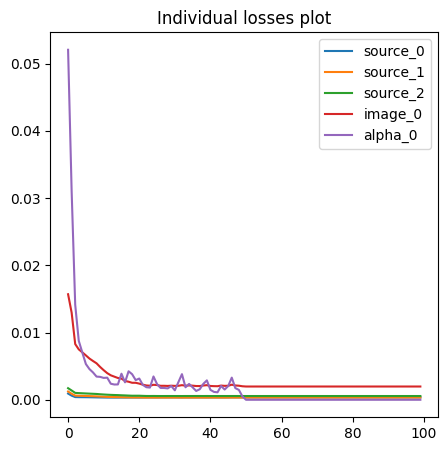

In [10]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

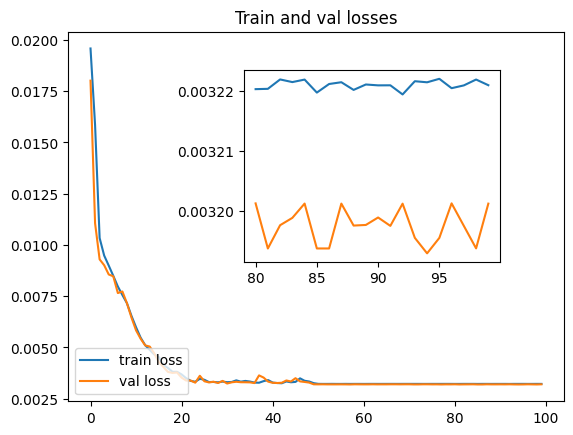

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['loss'][int(0.8*EPOCHS):],label='train loss')
axes_2.plot(range(int(0.8*EPOCHS),EPOCHS),history['val_loss'][int(0.8*EPOCHS):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [12]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.0031937663831437626


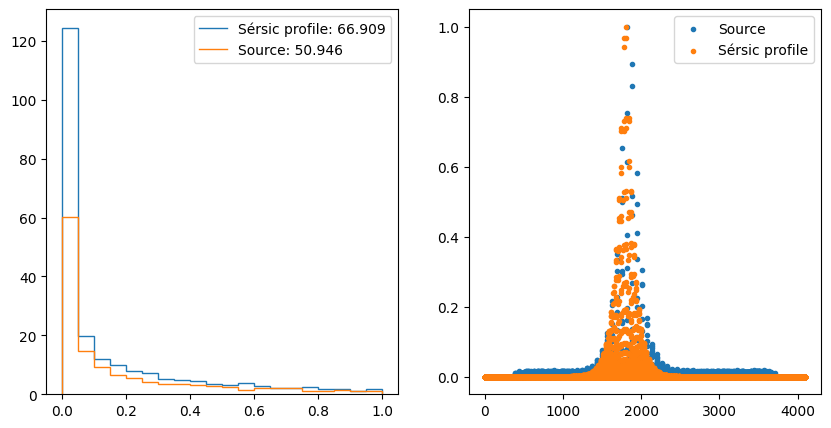

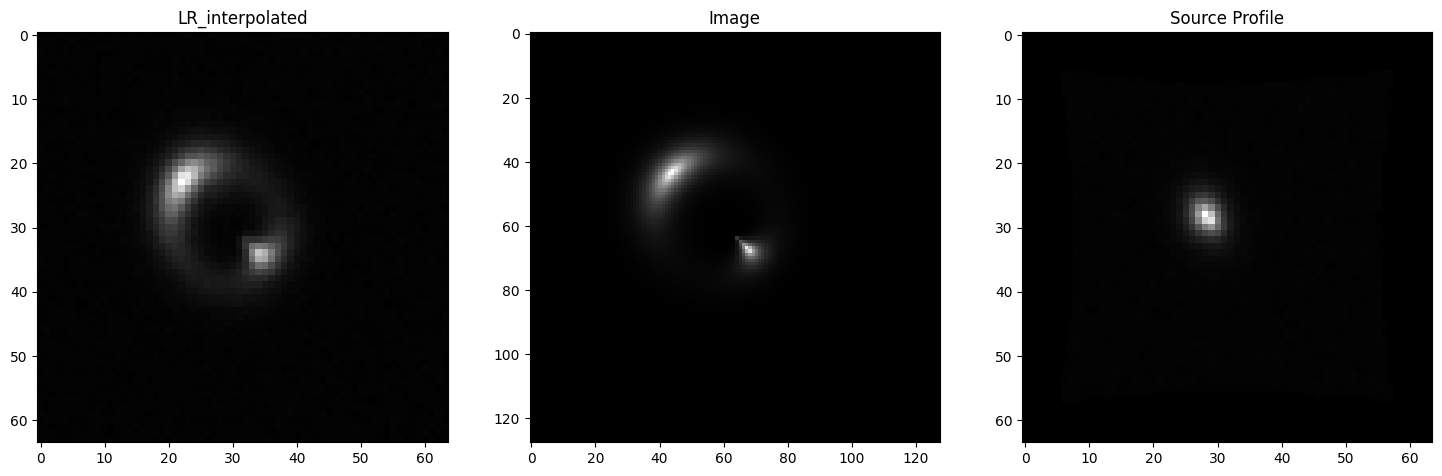

In [13]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [14]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [16]:
torch.save(best_weights, 'Weights_2.pt')